In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [3]:
# import zipfile
# corpus_zip = zipfile.ZipFile('/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.zip', 'r')
# recipe_str = corpus_zip.read(corpus_zip.namelist()[0])
# recipe = json.loads(recipe_str)

In [4]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.json"
# op_file_path = "data/ing_density.csv"
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer1.json"
op_file_path = "../../data/ing_density.csv"

with open(filepath) as json_data:
    recipe = json.load(json_data)

In [15]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer2.json"
# filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer2.json"
# with open(filepath) as json_data:
#     recipe_images = json.load(json_data)

In [6]:
unit_abbreviation = { 'tbsp' : ['tbsp', "tablespoon","tablespoons"],
                      'tsp' : ['tsp', 'teaspoon', 'teaspoons'],
                     'ml' : ['ml', 'milliliter','milliliters'],
                     'cup' : ['cups','cup'],
                     'oz' : ['ounces','oz', 'ounce'] , 
                     'lb' : ['pound','lb','lbs','lbs.']
}

In [7]:
# # loading recipe
# dict_ingredients= recipe_load(n=2, recipe=recipe)
# df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
# df_combined_ing

In [8]:
# Set input file directory
ip_file_dir = "../../data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [9]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [10]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('../../data/embeddings/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('../../data/embeddings/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [11]:
# Get random recipe from the 1M recipe corpus
# i = random.randint(0, 1000000)
# print(i)
dict_ingredients= recipe_load_index(4623, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(float)


qty = Qty_normal_map(unit_abbreviation = unit_abbreviation, op_file_path= op_file_path)
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = df_combined_ing.groupby(by=['ingredient', 'normalized_unit'], 
                                               as_index = False)\
                                      .agg({'quantity': 'sum', 'Volume_in_ml': 'sum'})
#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


Recipe: Chicken Cordon Bleu Roll-Ups


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:56: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [12]:
# import matplotlib.pyplot as plt
# urls = []
# for recipe_image in recipe_images:
#     if recipe_image['id'] == 'ca596d5fad':
#         for image in recipe_image['images']:
#             urls.append(image['url'])
# images = pm.get_images_urls(urls)

# plt.figure(figsize=(20,10))
# columns = 3
# for i in range(len(images)):
#     ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
#     plt.axis('off')
#     # plt.title(titles[i])
#     plt.imshow(images[i])

In [31]:
recipe[4623]

{'ingredients': [{'text': '1 tube crescent rolls'},
  {'text': '1 tbsp. extra-virgin olive oil'},
  {'text': '3/4 lb. Boneless Skinless Chicken Breast'},
  {'text': '3 tbsp. dijon'},
  {'text': '1 tsp. honey'},
  {'text': '1/2 lb. thinly sliced deli ham'},
  {'text': '1/4 lb. thinly sliced gruyere'}],
 'url': 'http://www.delish.com/cooking/recipe-ideas/recipes/a44346/chicken-cordon-bleu-roll-ups-recipe/',
 'partition': 'test',
 'title': 'Chicken Cordon Bleu Roll-Ups',
 'id': '01230b9a65',
 'instructions': [{'text': 'Preheat oven to 350 degrees F. On a floured work surface, roll out crescent rolls into one large rectangle, pinching together seams.'},
  {'text': 'In a large skillet over medium-high heat, heat oil.'},
  {'text': 'Cook chicken until cooked through and golden, 4 to 6 minutes per side.'},
  {'text': 'Transfer to a cutting board and thinly slice.'},
  {'text': 'In a small bowl, stir together Dijon and honey.'},
  {'text': 'Spread honey mustard all over Crescent rectangle and 

In [32]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,Boneless Skinless Chicken Breast,lb,0.75,360.0,"(4.0, 113.0, oz)",4.0,113.0,oz
1,dijon,tbsp,3.00,45.0,"(1.0, 15.0, tablespoon)",1.0,15.0,tablespoon
2,extra-virgin olive oil,tbsp,1.00,15.0,"(100.0, 90.7, )",100.0,90.7,
3,honey,tsp,1.00,5.0,"(1.0, 339.0, cup)",1.0,339.0,cup
4,thinly sliced deli ham,lb,0.50,240.0,"(None, None, )",NaN,NaN,
5,thinly sliced gruyere,lb,0.25,120.0,"(None, None, )",NaN,NaN,
6,tube crescent rolls,count,1.00,0.0,"(None, None, )",NaN,NaN,


In [33]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients, 3)

rslt_df = group10[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value', 'package_weight_unit_of_measure','package_weight']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group10['tcin'].isin(ranked_match[i])] 
    ing = recipe_ingredients[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'ingredient']=ing
                break
       
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

#matching target database with recipe 
join_df = pd.merge(final_rslt_df, final_df, 
                   how = 'left', on = 'ingredient')

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price'])
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']]

yes tube crescent rolls


/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
print("Recipe: Chicken Cordon Bleu Roll-Ups")

Recipe: Chicken Cordon Bleu Roll-Ups


In [14]:
recipe[4623]

{'ingredients': [{'text': '1 tube crescent rolls'},
  {'text': '1 tbsp. extra-virgin olive oil'},
  {'text': '3/4 lb. Boneless Skinless Chicken Breast'},
  {'text': '3 tbsp. dijon'},
  {'text': '1 tsp. honey'},
  {'text': '1/2 lb. thinly sliced deli ham'},
  {'text': '1/4 lb. thinly sliced gruyere'}],
 'url': 'http://www.delish.com/cooking/recipe-ideas/recipes/a44346/chicken-cordon-bleu-roll-ups-recipe/',
 'partition': 'test',
 'title': 'Chicken Cordon Bleu Roll-Ups',
 'id': '01230b9a65',
 'instructions': [{'text': 'Preheat oven to 350 degrees F. On a floured work surface, roll out crescent rolls into one large rectangle, pinching together seams.'},
  {'text': 'In a large skillet over medium-high heat, heat oil.'},
  {'text': 'Cook chicken until cooked through and golden, 4 to 6 minutes per side.'},
  {'text': 'Transfer to a cutting board and thinly slice.'},
  {'text': 'In a small bowl, stir together Dijon and honey.'},
  {'text': 'Spread honey mustard all over Crescent rectangle and 

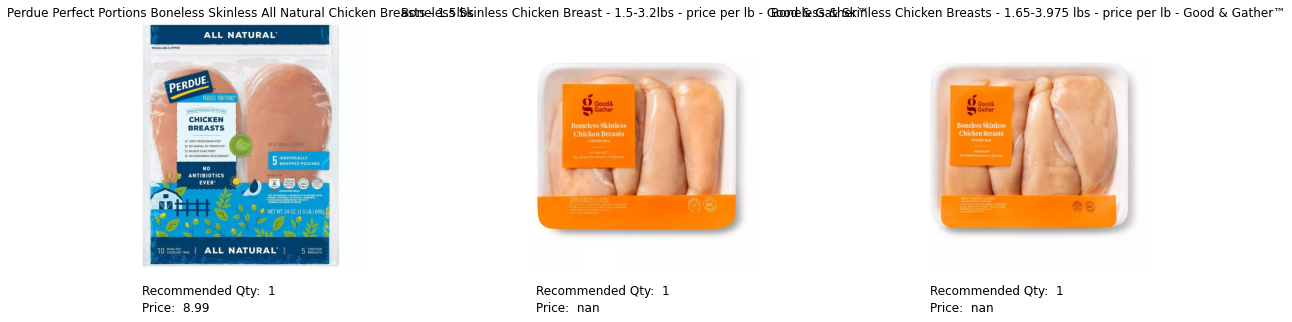

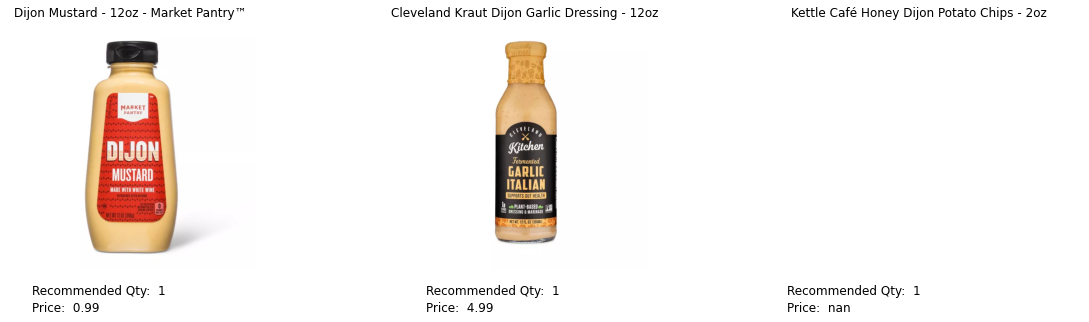

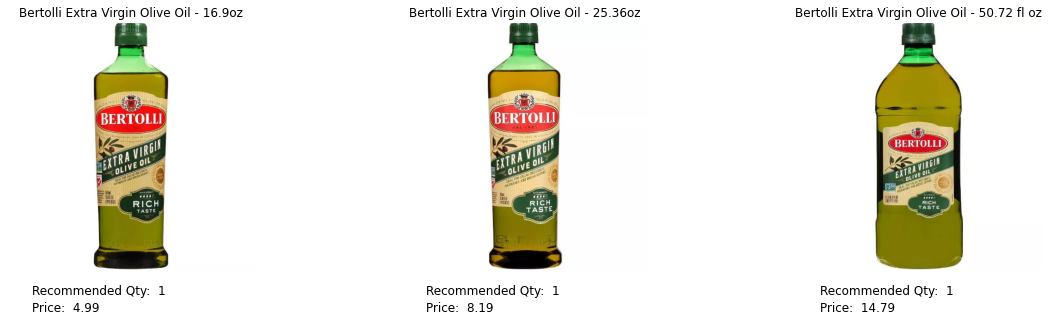

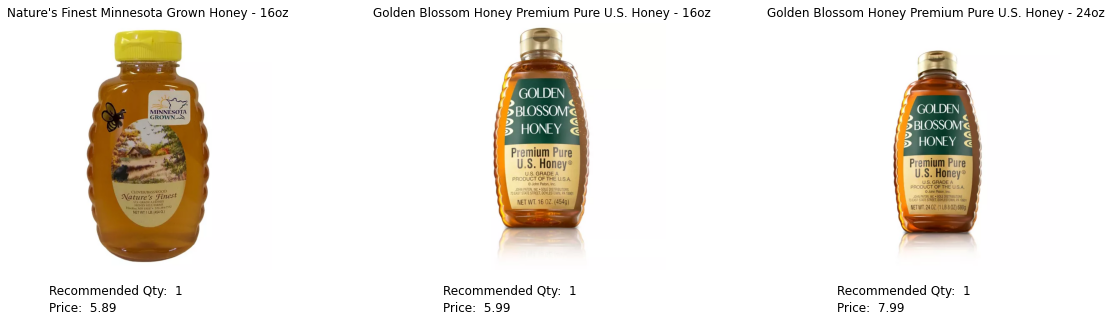

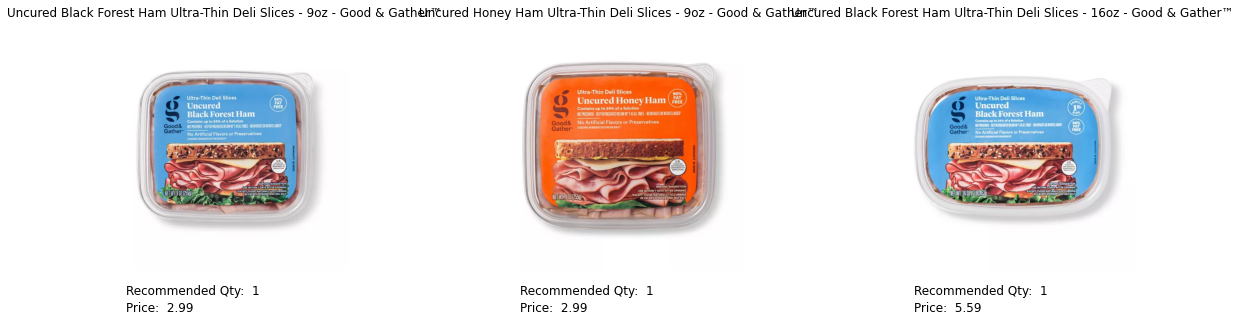

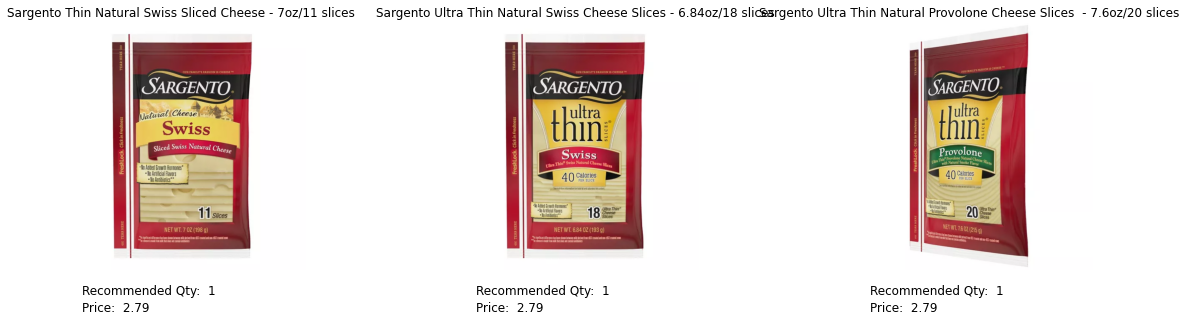

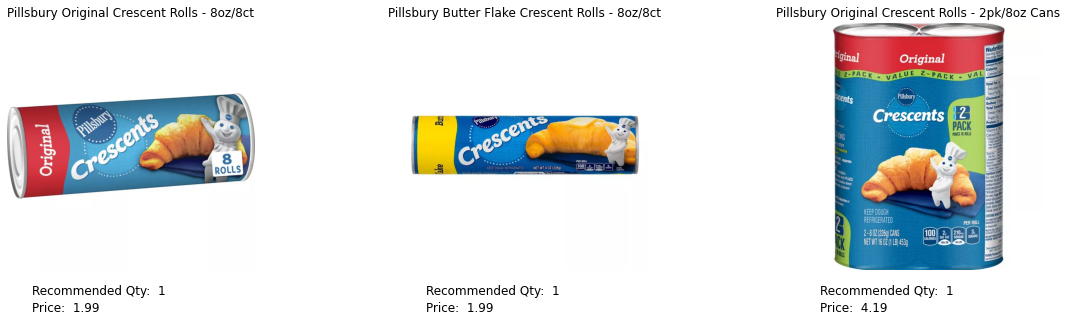

In [35]:
dp.display_products_df(display_df, 3)

In [ ]:
#4567
#7609
#32659
#4623